In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from collections import OrderedDict

import jax.numpy as jnp
from jax import value_and_grad, grad, jit, vmap, partial
from jax import random, ops, lax

import context 

from examples.PMF.pmf_model import grad_log_post
from examples.PMF.util import R_train, R_test, flatten_PMF_params, load_PMF_MAP
from examples.PMF.sgld_PMF_functions import sgld_PMF_time_budget_CV, sgld_PMF_time_budget, sgld_PMF_time_budget_svrg
from examples.PMF.sghmc import run_sghmc_PMF_time_budget

from successive_halving.sh import Base_SGLD_SuccHalv_Time, run_SH_time_budget_keep_3
from successive_halving.sh import create_T_list_sghmc, create_T_list_2params, create_T_list_svrg

from ksd import imq_KSD
from util import wait_until_computed

/Users/jeremiecoullon/Documents/research/papers/SGMCMC_bandit_tuning/venv/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/jeremiecoullon/Documents/research/papers/SGMCMC_bandit_tuning/venv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
flatten_PMF_params([load_PMF_MAP()]).shape

(1, 52580)

# SH for PMF

_April 2021_


sgld with `b_s_r=0.1`: 5K samples in 10 seconds

In [3]:
key = random.PRNGKey(0)
MAP_params = load_PMF_MAP()
# dt = 1e-6
# batch_size = int(0.1*R_train.shape[0])

dt = 10**(-4.65)
batch_size = int(0.016*R_train.shape[0])

time_budget = 1

a, b = sgld_PMF_time_budget(key, time_budget, grad_log_post, dt, batch_size, MAP_params, R_train, save_rate=30)

flat_samples = flatten_PMF_params(a)
flat_grads = flatten_PMF_params(b)

# imq_KSD(flat_samples, flat_grads)
print(flat_samples.shape)

print(f"Total samples: {flat_samples.shape[0]*30}")

/Users/jeremiecoullon/Documents/research/papers/SGMCMC_bandit_tuning/venv/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


(13, 52580)
Total samples: 390


In [5]:
flat_samples.shape

(13, 52580)

In [6]:
# plt.plot(flat_samples[:,0])

In [7]:

class PMF_succ_halving_sgld(Base_SGLD_SuccHalv_Time):

    def __init__(self, key, logdt, batch_size_ratio, thin_step):
        self.key = key
        self.logdt = logdt
        self.save_rate = thin_step
        self.batch_size_ratio = batch_size_ratio
        self.x_0 = load_PMF_MAP()
        self.last_sample = None
        super(PMF_succ_halving_sgld, self).__init__(self.key, self.logdt, self.x_0)

    def _run_sampler(self, key, time_budget, x_0):
        dt = 10**self.logdt
        batch_size = int(self.batch_size_ratio*R_train.shape[0])
        samples, grads = sgld_PMF_time_budget(key, time_budget, grad_log_post, dt, 
                                              batch_size, x_0, R_train, save_rate=self.save_rate)
        if samples == []:
            return None, None
        else:
            pass
        try:
            self.last_sample = samples[-1]
        except:
            pass
        flat_samples = flatten_PMF_params(samples)

        full_batch_grads = [grad_log_post(sam, R_train) for sam in samples]
        flat_grads = flatten_PMF_params(full_batch_grads)
        return flat_samples, flat_grads

    def get_ksd(self):
        try:
            if any(np.isnan(self.samples[-1])):
                return 1e10
            else: pass
            self.KSD = imq_KSD(self.samples, self.grads)
            return self.KSD
        except:
            return 1e10

    def get_last_sample(self):
        return self.last_sample

7
Calculating KSD..


14
Calculating KSD..


[DeviceArray(1362.0221, dtype=float32), DeviceArray(1140.2308, dtype=float32)]


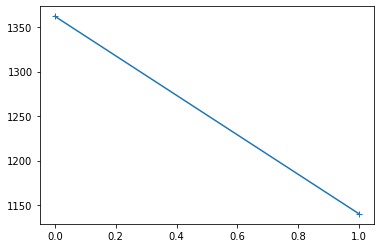

In [8]:

key = random.PRNGKey(0)
pmf_my_sgld = PMF_succ_halving_sgld(key, -6., 0.1, 30)

num_l = 2
ksd_list = []

for i in range(num_l):
    pmf_my_sgld.run(1)
    print(pmf_my_sgld.len_samples)
    print("Calculating KSD..")
    ksd_list.append(pmf_my_sgld.get_ksd())
    print("\n")

plt.plot(ksd_list, marker="+")
print(ksd_list)

# Successive halving

## 1. sgld

In [4]:

R = 8 # total time budget for longest runs
n = 90 # number of step sizes to try at first
r = R/40
thin_step = 30
eta = 3 # cut trials by 3 every time

print(f"r={r:.3f}")
key = random.PRNGKey(2)

sampler_dict_sgld = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                                  PMF_succ_halving_sgld, create_T_list_2params, R_train.shape[0])

r=0.200
Number of iterations: 4
Total budget: around 72 sec
=====

Iteration 0: 90 configurations with 0.200 seconds each
Combinations: [(-5.6809406, 0.035111915), (-4.8188696, 0.24770762), (-3.1054559, 0.046415884), (-2.8742738, 0.869749), (-6.927352, 1.0), (-2.0856218, 0.017475285), (-2.124608, 0.07054803), (-4.2174926, 0.018738173), (-2.953824, 0.010722672), (-6.1667485, 0.75646335), (-5.401692, 0.043287612), (-4.943814, 0.4328761), (-4.1000185, 0.16297507), (-3.4697778, 0.010722672), (-6.300881, 0.46415886), (-6.246524, 0.021544348), (-4.6608067, 0.061359067), (-6.8173018, 0.1), (-2.2085094, 0.001629751), (-5.4803066, 0.004977024), (-3.4399357, 0.0015199113), (-3.0746777, 0.0021544343), (-4.885751, 0.0012328465), (-3.1537957, 0.011497568), (-5.071318, 0.65793324), (-5.0046825, 1.0), (-6.1107597, 0.0075646355), (-6.770213, 0.1), (-4.605062, 0.40370172), (-5.664422, 0.13219412), (-2.3886995, 1.0), (-6.7092285, 0.04977024), (-4.154315, 0.014174741), (-2.297781, 0.0132194115), (-2.1183

In [14]:
# key = 1
# running time:  3min 40 (ie: 208 seconds)
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.4756784, 0.01) 6720 218.73192
(-4.556988, 0.021544348) 4980 256.13895
(-4.6571603, 0.037649363) 4380 284.93756


In [18]:
# key = 2
# running time: 197 sec
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.6733375, 0.023101298) 6390 242.5495
(-4.7116795, 0.010722672) 5190 279.15503
(-5.0694075, 0.003764935) 5880 339.99545


In [16]:
# key = 3
# running time: 197 sec
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.7116795, 0.010722672) 6810 245.65512
(-4.6733375, 0.023101298) 5910 251.74567
(-5.0694075, 0.003764935) 6600 324.1349


## 2. svgr sampler

In [5]:
# run sampler

time_budget = 2
dt = 1e-5
update_rate = 1000
batch_size = int(R_train.shape[0]*0.1)
params_IC = load_PMF_MAP()
key = random.PRNGKey(0)

samples_svrg, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, params_IC, R_train, update_rate, save_rate=30)

print(len(samples_svrg)*30)

630


In [2]:
class PMF_succ_halving_svrg(Base_SGLD_SuccHalv_Time):
    
    def __init__(self, key, logdt, batch_size_ratio, thin_step):
        self.key = key
        self.logdt = logdt
        self.save_rate = thin_step
        self.update_rate = 1000 # fix update_rate
        self.batch_size_ratio = batch_size_ratio
        self.x_0 = load_PMF_MAP()
        self.last_sample = None
        super(PMF_succ_halving_svrg, self).__init__(self.key, self.logdt, self.x_0)
        
    def _run_sampler(self, subkey, time_budget, x_0):
        dt = 10**self.logdt
        batch_size = int(self.batch_size_ratio*R_train.shape[0])
        samples, grads = sgld_PMF_time_budget_svrg(key=key, time_budget=time_budget, 
                                                   grad_log_post=grad_log_post, dt=dt,
                                                   batch_size=batch_size, params_IC=x_0, 
                                                   R_train=R_train, update_rate=self.update_rate, 
                                                   save_rate=self.save_rate)
        if samples == []:
            return None, None
        else:
            pass
        try:
            self.last_sample = samples[-1]
        except:
            pass    
        flat_samples = flatten_PMF_params(samples)
        full_batch_grads = [grad_log_post(sam, R_train) for sam in samples]
        flat_grads = flatten_PMF_params(full_batch_grads)
#         flat_grads = flatten_PMF_params(grads)
        
        return flat_samples, flat_grads
    
    def get_ksd(self):
        try:
            if any(np.isnan(self.samples[-1])):
                return 1e10
            else: pass
            self.KSD = imq_KSD(self.samples, self.grads)
            return self.KSD
        except:
            return 1e10
    
    def get_last_sample(self):
        return self.last_sample
    


##### test

In [10]:

key = random.PRNGKey(0)
pmf_my_sgld = PMF_succ_halving_svrg(key, -7., 0.1, 30)

pmf_my_sgld.run(5)
print(pmf_my_sgld.get_ksd())
print(pmf_my_sgld.len_samples)


1325.234
51


In [13]:

key = random.PRNGKey(0)
pmf_my_sgld = PMF_succ_halving_svrg(key, -7., 0.1, 30)

pmf_my_sgld.run(1)
print(pmf_my_sgld.get_ksd())
print(pmf_my_sgld.len_samples)

pmf_my_sgld.run(2)
print(pmf_my_sgld.get_ksd())
print(pmf_my_sgld.len_samples)

pmf_my_sgld.run(2)
print(pmf_my_sgld.get_ksd())
print(pmf_my_sgld.len_samples)

1730.7998
9
1572.7037
27
1436.7401
47


#### run SH

In [3]:



R = 12 # total time budget for longest runs
n = 90 # number of step sizes to try at first
r = R/40
thin_step = 30


eta = 3 # cut trials by 3 every time

print(f"r={r:.3f}")
key = random.PRNGKey(0)


sampler_dict_svrg = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                               PMF_succ_halving_svrg, create_T_list_2params, R_train.shape[0])


r=0.300
Number of iterations: 4
Total budget: around 108 sec
=====

Iteration 0: 90 configurations with 0.300 seconds each
Combinations: [(-2.9291453, 0.93260336), (-6.4782596, 0.00811131), (-5.5711884, 0.024770763), (-4.7319803, 0.003764935), (-6.044933, 0.0053366995), (-4.836668, 0.015199109), (-3.7557585, 0.017475285), (-3.0864086, 0.869749), (-2.750773, 0.49770236), (-6.2133875, 0.0061359066), (-6.2843676, 0.020092327), (-5.797586, 0.0053366995), (-2.1424685, 0.4328761), (-3.8307626, 0.017475285), (-2.713562, 0.0013219408), (-3.0279179, 0.010722672), (-4.327333, 0.0010722672), (-5.3738036, 0.037649363), (-5.0438943, 0.16297507), (-5.0316076, 0.0010722672), (-2.7530785, 0.14174742), (-2.9914374, 0.040370174), (-3.1181636, 0.0028480361), (-5.4463973, 0.5722368), (-5.470988, 0.020092327), (-2.6559381, 0.0035111913), (-3.0144324, 0.13219412), (-6.1687517, 0.16297507), (-6.3341594, 0.057223674), (-4.1798353, 0.010722672), (-6.433, 0.869749), (-3.1092925, 0.0012328465), (-5.62562, 0.1149

In [10]:
1620/60



27.0

In [22]:
# key = 0
# running time: 10 minutes

for k,v in sampler_dict_svrg.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.7319803, 0.003764935) 4110 362.3592
(-4.685914, 0.00811131) 3570 373.66016
(-5.0316076, 0.0010722672) 4080 464.83414


In [24]:
# key = 1
# running time:  minutes

for k,v in sampler_dict_svrg.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.4879274, 0.026560875) 3480 324.85187
(-4.7200546, 0.03274549) 3390 388.56885
(-5.008625, 0.0021544343) 4080 453.53262


In [26]:
# key = 2
# running time: 3 minutes

for k,v in sampler_dict_svrg.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.494991, 0.002310129) 5370 267.03976
(-4.700827, 0.028480362) 3690 365.56448
(-4.885751, 0.0012328465) 4800 382.11862


# =====

In [27]:
# key = 0
# running time: 20 minutes

for k,v in sampler_dict_svrg.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-5.06294, 0.00853168, 9213) 5400 432.51602
(-5.1706333, 0.006723357, 2474) 4900 490.37714
(-5.278665, 0.0025929436, 5047) 5050 525.8042


In [29]:
# key = 1
# running time:  26 minutes

for k,v in sampler_dict_svrg.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.9936266, 0.010826366, 288) 3550 493.4561
(-5.1087084, 0.010826366, 9336) 4200 493.57773
(-5.238054, 0.001610262, 8689) 4500 532.3123


In [32]:
# key = 2
# running time:  20 minutes

for k,v in sampler_dict_svrg.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-4.5566716, 0.00853168, 8770) 5400 299.8976
(-4.6890903, 0.005298318, 7146) 5450 327.09756
(-4.586671, 0.001610262, 132) 4700 329.3052


# SH: sghmc

In [18]:
time_budget = 10

key = random.PRNGKey(1)
# dt = 1e-5
# batch_size = int(R_train.shape[0]*0.05)
# L = 10

dt = 10**(-3.31)
batch_size = int(R_train.shape[0]*0.1)
L = 2
params = load_PMF_MAP()
# params = deepcopy(samples_pmf_sghmc[-1])


samples_pmf_sghmc, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                                 L, R_train, params, save_rate=10)

# samples_pmf_sghmc = samples_pmf_sghmc + samples_pmf_sghmc2

Iteration 1000. Time: 4 / 10 sec
Iteration 2000. Time: 8 / 10 sec


In [19]:
flat_samples = flatten_PMF_params(samples_pmf_sghmc)
full_batch_grads = [grad_log_post(sam, R_train) for sam in samples_pmf_sghmc]
flat_grads = flatten_PMF_params(full_batch_grads)

In [20]:
print(imq_KSD(flat_samples, flat_grads))

nan


In [27]:
flat_samples.shape

(248, 52580)

In [49]:

key = random.PRNGKey(1)
pmf_my_hmc = PMF_succ_halving_HMC_L(key, -3.31, 0.1, 2, 30)

pmf_my_hmc.run(1)
print(pmf_my_hmc.get_ksd())

1653.1229


In [50]:
pmf_my_hmc.run(9)
print(pmf_my_hmc.get_ksd())

10000000000.0


In [3]:
class PMF_succ_halving_HMC_L(Base_SGLD_SuccHalv_Time):
    
    def __init__(self, key, logdt, batch_size_ratio, L, thin_step):
        self.key = key
        self.logdt = logdt
        self.batch_size_ratio = batch_size_ratio
        self.x_0 = load_PMF_MAP()
        self.L = L
        self.thin_step = thin_step
        self.last_sample = None
        super(PMF_succ_halving_HMC_L, self).__init__(self.key, self.logdt, self.x_0)
        
    def _run_sampler(self, key, time_budget, x_0):
        dt = 10**self.logdt
        batch_size = int(self.batch_size_ratio*R_train.shape[0])
        samples, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, 
                                 batch_size, self.L, R_train, x_0, save_rate=self.thin_step, print_rate=10000)
        if samples == []:
            return None, None
        else:
            pass
        try:
            self.last_sample = samples[-1]
        except:
            pass    
        flat_samples = flatten_PMF_params(samples)
        full_batch_grads = [grad_log_post(sam, R_train) for sam in samples]
        flat_grads = flatten_PMF_params(full_batch_grads)
        
        return flat_samples, flat_grads
    
    def get_ksd(self):
        try:
            if any(np.isnan(self.samples[-1])):
                return 1e10
            else: pass
            self.KSD = imq_KSD(self.samples, self.grads)
            return self.KSD
        except:
            return 1e10
    
    def get_last_sample(self):
        return self.last_sample
    

    


#### test

In [4]:

key = random.PRNGKey(0)
pmf_my_hmc = PMF_succ_halving_HMC_L(key, -7., 0.1, 10, 30)

pmf_my_hmc.run(1)
print(pmf_my_hmc.get_ksd())

pmf_my_hmc.run(2)
print(pmf_my_hmc.get_ksd())

pmf_my_hmc.run(2)
print(pmf_my_hmc.get_ksd())

2294.1963
1403.4414
1157.0057


In [52]:
R = 30
thin_step = 5
r = R/40 # number of samples per run
n = 120 # number of step sizes to try at first
eta = 3 # cut trials by 3 every time

key = random.PRNGKey(8)

sampler_dict_hmc = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                               PMF_succ_halving_HMC_L, create_T_list_sghmc, R_train.shape[0])



Number of iterations: 4
Total budget: around 360 sec
=====

Iteration 0: 120 configurations with 0.750 seconds each
Combinations: [(-3.5285106, 0.04977024, 19), (-5.779764, 0.7054802, 21), (-2.4292178, 0.3274549, 24), (-3.2023854, 0.01, 16), (-3.6723104, 0.014174741, 27), (-3.101019, 0.08111308, 20), (-4.030316, 0.001, 5), (-6.7508497, 0.0013219408, 10), (-2.348898, 0.026560875, 25), (-5.3350983, 0.24770762, 7), (-2.302621, 0.46415886, 19), (-3.7331867, 0.24770762, 11), (-5.315778, 0.006579331, 8), (-5.546077, 0.030538555, 21), (-5.8189907, 0.009326034, 2), (-4.714668, 0.0057223677, 25), (-3.6084898, 0.028480362, 18), (-3.3947487, 0.0070548006, 3), (-5.495061, 0.0028480361, 6), (-4.0723734, 0.023101298, 28), (-2.0865011, 0.65793324, 16), (-6.4801397, 0.0017475284, 10), (-2.4497032, 0.0012328465, 16), (-2.5350113, 0.49770236, 6), (-2.0575447, 0.030538555, 22), (-2.3553524, 0.046415884, 5), (-5.1926365, 0.023101298, 17), (-6.759248, 0.46415886, 9), (-4.117991, 0.0014174745, 6), (-4.24042

In [15]:
# key = 9
# thin = 5, R=30
# running time: 20 minutes

for k,v in sampler_dict_hmc.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-5.3350105, 0.08111308, 3) 5325 253.92917
(-6.3196335, 0.01, 5) 5235 316.06213
(-4.62419, 0.026560875, 8) 3070 333.89978


In [53]:
# key = 8
# R = 30
# thin_step = 5
# running time: 30 minutes

for k,v in sampler_dict_hmc.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-5.2730336, 0.017475285, 2) 6830 300.9591
(-5.9622393, 0.0021544343, 4) 2700 374.44083
(-5.9110856, 0.001, 3) 3620 427.28174


In [11]:
# key = 11
# R = 30
# thin_step = 5
# running time: 36 minutes
for k,v in sampler_dict_hmc.items():
    print(k, v.len_samples*thin_step, v.KSD)

(-5.1853337, 0.07054803, 2) 5925 295.4544
(-3.222281, 0.3274549, 2) 3215 310.31375
(-6.2675595, 0.0030538556, 6) 3295 315.45972
